# Machine Failure
Using Kaggle dataset https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions/data


## Libraries

In [34]:
# 3rd party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
try:
    import dtreeviz
    %config InlineBackend.figure_format = 'retina' # Make visualizations look good
except:
    print('Please run "conda uninstall python-graphviz; conda uninstall graphviz; pip install dtreeviz" to install the tree visualization library')   
%matplotlib inline

# standard library
import time

# internal imports
from exploratory_analysis import util  # make_difference_features, make_multiplicative_features, calculate_and_display_accuracy

# constants
RANDOM_SEED = 42
TEST_SIZE = 0.25

## Importing Data 

In [14]:
data = pd.read_csv("machine failure.csv")
print(data.head(), type(data))

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [3]:
data.shape

(10000, 14)

In [4]:
data.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [5]:
data.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

The dataset is composed of numerical and categorical data types. This dataset did not contain any NA values.

## Preliminary Stats

### Features
From this dataset, udi, productID, product type, air temperature, process temperature, rotational speed, torque, tool wear, machine failure, tool wear failure, heat dissipation failure, power failure, overstrain failure, and random failures as features. UDI and productId are redundant in purpose, so one can be dropped.
https://www.kaggle.com/code/zakikurdya/predictive-maintenance#Dataset-Description-%F0%9F%93%83 for insight on which each feature means and how it was measured.

#### Numerical Features

In [6]:
data.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


C:\Users\hzuo\AppData\Local\Temp\ipykernel_16788\662502500.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.


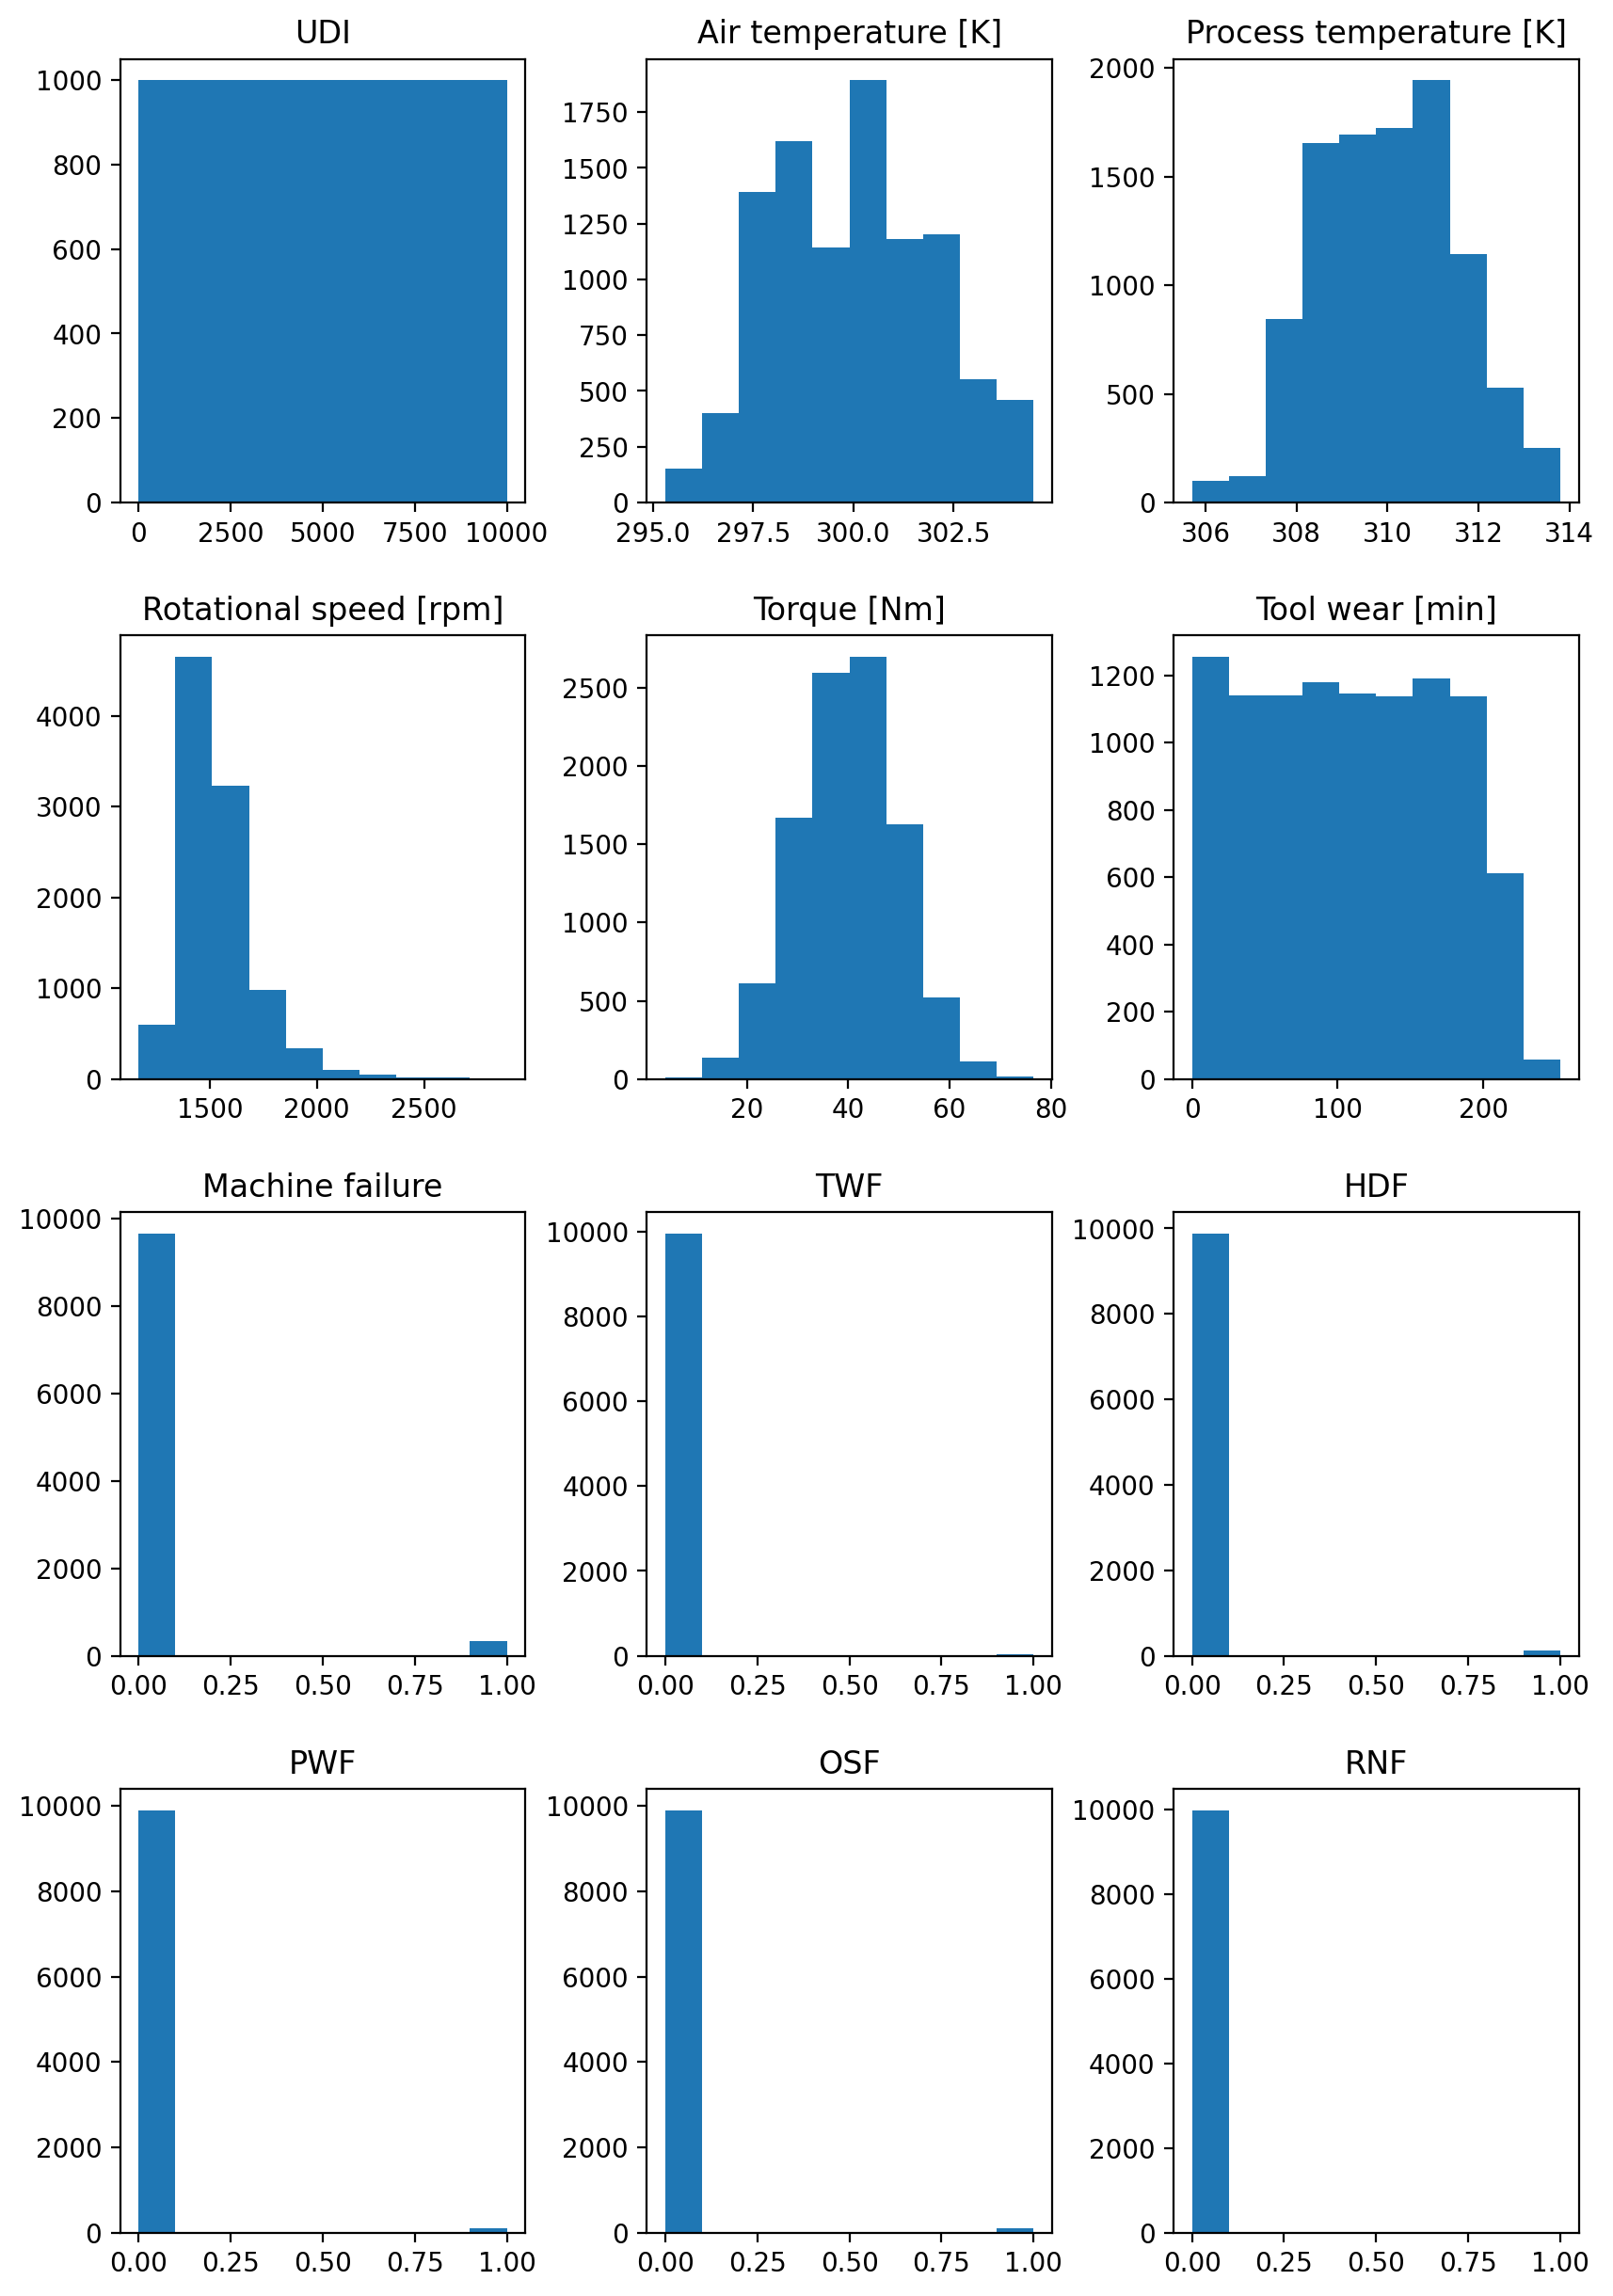

In [7]:
fig = plt.figure(figsize=(10,15))
ax = fig.gca()

data.hist(ax= ax, grid= False);

So far, torque is the only feature that follows a normal distribution. The features machine failure, TWF, HDF, PWF, OSF, and RNF are discrete variables.

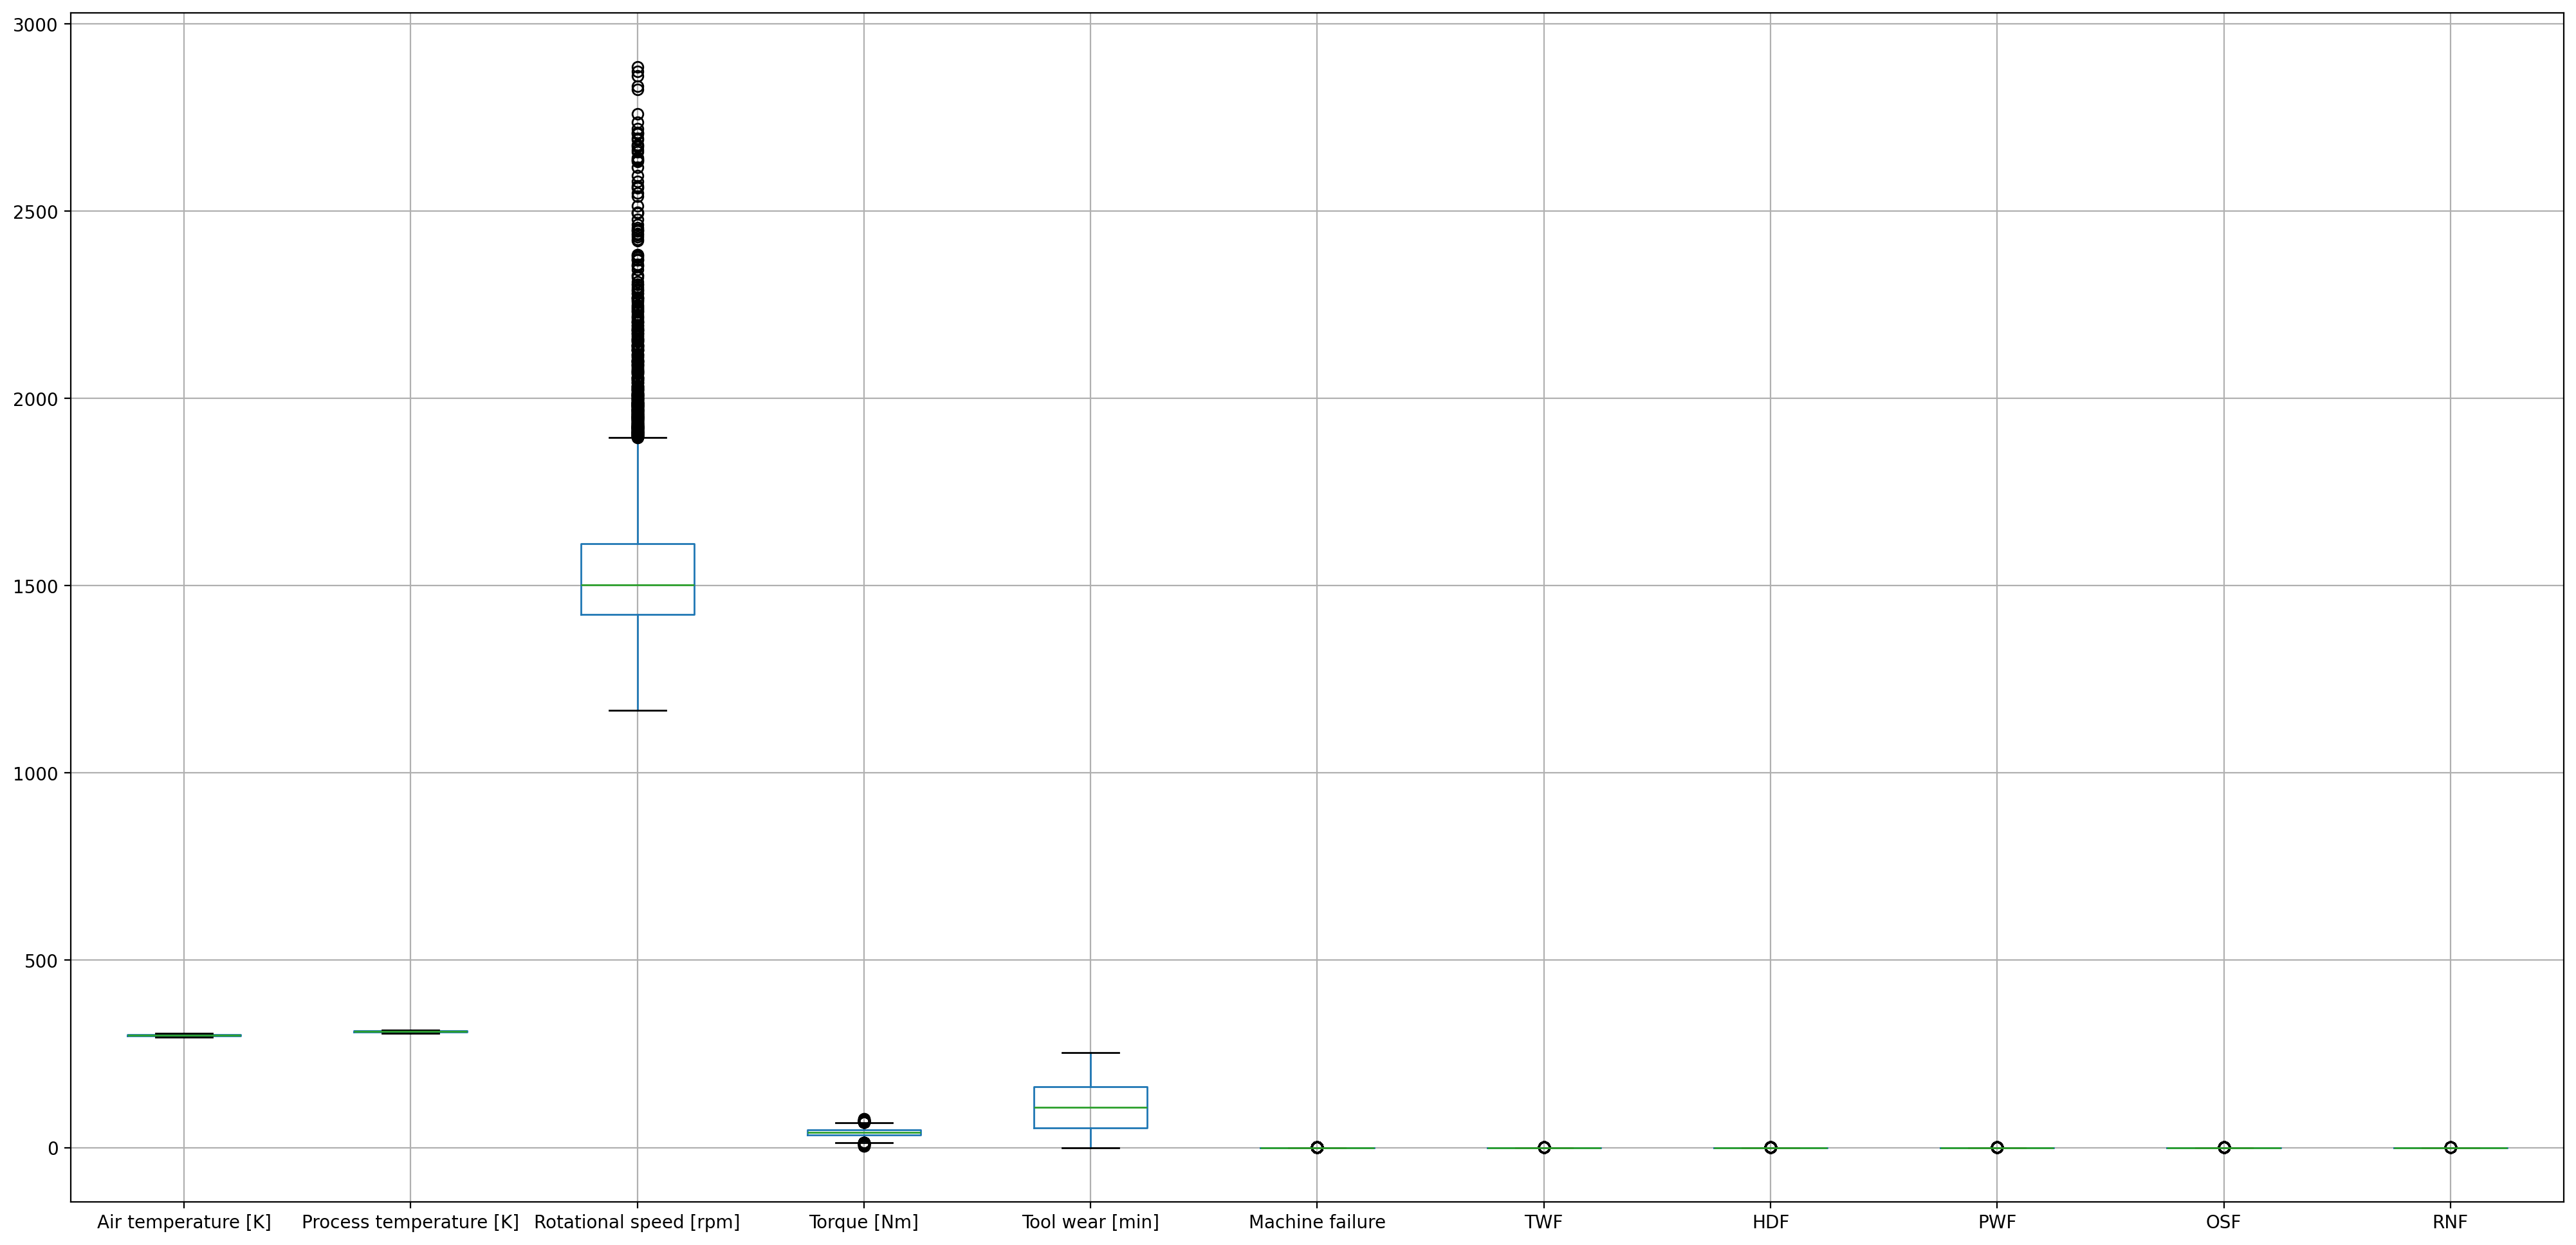

In [8]:
fig = plt.figure(figsize=(25,12))
ax = fig.gca()

data.boxplot(column= ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']);

#### Categorical Features

In [9]:
pid = data.iloc[:,1]
pid.nunique()

10000

In [10]:
types = data.iloc[:,2]
types.unique()

array(['M', 'L', 'H'], dtype=object)

Since the ProductID is a unique identifier, it can be replaced with standard indexing. Also, the L, M, H product types are redundant through out the set of data. We will create dummies from this column of data.

## New Section - Split and Standardization

In [17]:
# if the failure is not a twf, hdf, pwf, or osf then it is treated as a non failure
copied_data = data.copy()
copied_data['Machine failure'] = np.where((copied_data['TWF'] == 1) | (copied_data['HDF'] == 1) | (copied_data['PWF'] == 1) | (copied_data['OSF'] == 1), 1, 0)
copied_data.drop(['UDI','Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

# directly map the quality without dummies
quality_map = {'L': 1, 'M': 2, 'H': 3}
copied_data['Type'] = copied_data['Type'].map(quality_map)

# add features
subtraction_columns = util.make_difference_features(copied_data.drop(columns=['Machine failure', 'Type']))
multiplication_columns = util.make_multiplicative_features(copied_data.drop(columns=['Machine failure', 'Type']))
copied_data = pd.concat([copied_data, subtraction_columns, multiplication_columns], axis=1)

# split
X = copied_data.drop(columns='Machine failure')
y = copied_data['Machine failure']
X_map_train, X_map_test, y_map_train, y_map_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)

# standardize
scaler = StandardScaler()
columns_to_scale = list(X_map_train.columns)
columns_to_scale.remove('Type')

X_map_train[columns_to_scale] = scaler.fit_transform(X_map_train[columns_to_scale])
X_map_test[columns_to_scale] = scaler.transform(X_map_test[columns_to_scale])

## New Section - Classification Performance by Model

### Random Forest

In [29]:
rf_model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, max_depth=13, max_features=0.88,
                                  min_samples_leaf=5, n_estimators=115)
rf_model.fit(X_map_train, y_map_train)

RandomForestClassifier(max_depth=13, max_features=0.88, min_samples_leaf=5,
                       n_estimators=115, n_jobs=-1, random_state=42)

In [30]:
util.calculate_and_display_accuracy(rf_model, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9951
Model Test accuracy:                                       0.9944
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9950666666666667, 0.9944, 0.9669333333333333, 0.9672)

In [31]:
test_predictions = rf_model.predict(X_map_test)

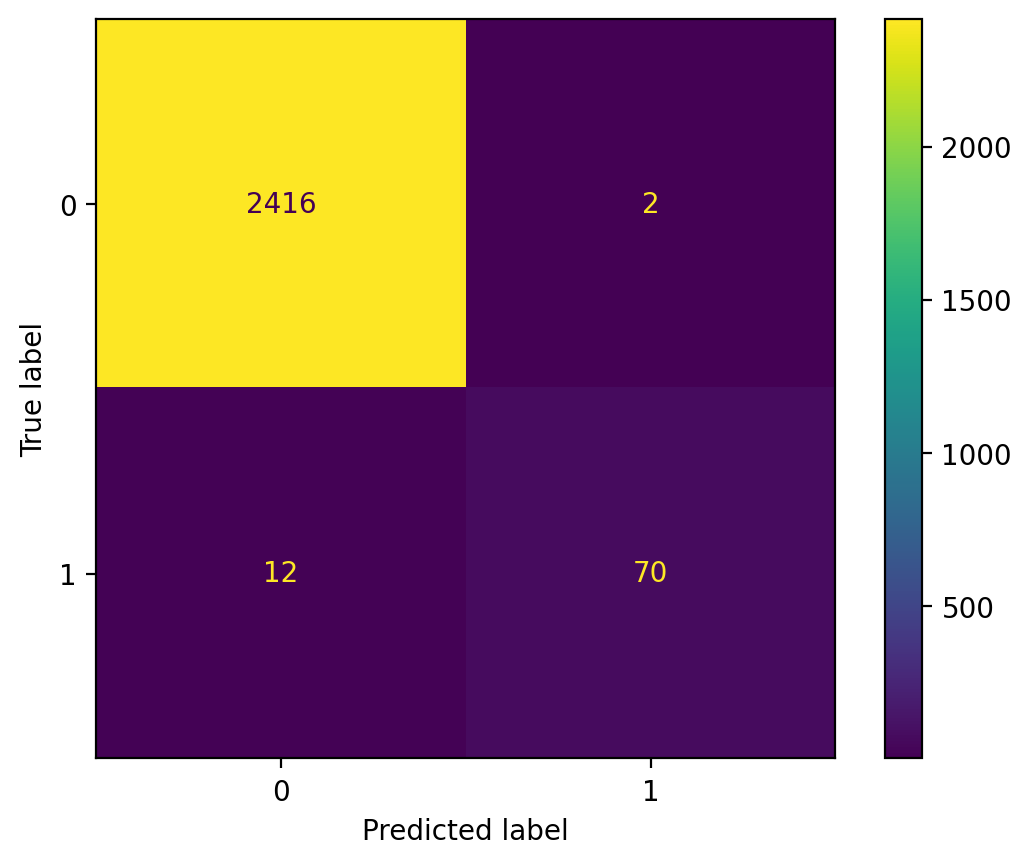

In [32]:
cm = confusion_matrix(y_map_test, test_predictions, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.savefig('random_forest_test_confusion_matrix.svg', format='svg', bbox_inches='tight')

In [37]:
print(classification_report(y_map_test, test_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2418
           1       0.97      0.85      0.91        82

    accuracy                           0.99      2500
   macro avg       0.98      0.93      0.95      2500
weighted avg       0.99      0.99      0.99      2500



## Analysis without Transformation and Categorical variables to Classify Machine Failure

### Classification

#### Random Forest 

#### Decision Trees 

#### Gradient Boosted Decision Trees

#### Extra Trees 

#### Logistic Regression

In [35]:
data.Type = pd.get_dummies(data.Type, drop_first=True, dtype=float)

feat = data.loc[:, 'Type':'RNF']

ValueError: Columns must be same length as key

## Principal Component Analysis

In [20]:
pca_1 = PCA(n_components = 1)
pca_2 = PCA(n_components = 2)
pca_3 = PCA(n_components = 3)

principalComponents = pca_1.fit_transform(feat)
principalComponents = pca_2.fit_transform(feat)
principalComponents = pca_3.fit_transform(feat)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

0.8875611058314048
0.99918076809843
0.999820914619854


## Splitting train and test data

In [21]:
X = data.drop(['UDI', 'Product ID','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = data['Machine failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Pipeline creation and accuracy score generation for Logistic Regression, Decision Tree Classifier, and Random Forest Classifier

In [22]:
#Logistic Regression
pipe_lr = Pipeline([('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(random_state=42))])
pipe_lr.fit(X_train, y_train)
print('Logistic Regression accuracy:', pipe_lr.score(X_test, y_test))

#Decision Tree Classifier
pipe_tree = Pipeline([('pca', PCA(n_components=2)),
                     ('clf', DecisionTreeClassifier(random_state=42))])
pipe_tree.fit(X_train, y_train)
print('Decision tree classifier accuracy:', pipe_tree.score(X_test, y_test))

#Random Forest
pipe_rf = Pipeline([('pca', PCA(n_components=2)),
                   ('clf', RandomForestClassifier(random_state=42))])
pipe_rf.fit(X_train, y_train)
print('Random forest classifier accuracy:', pipe_rf.score(X_test, y_test))

Logistic Regression accuracy: 0.9712
Decision tree classifier accuracy: 0.9484
Random forest classifier accuracy: 0.9692


In [23]:
data['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [24]:
data.TWF.value_counts()

0    9954
1      46
Name: TWF, dtype: int64

In [25]:
data.HDF.value_counts()

0    9885
1     115
Name: HDF, dtype: int64

In [26]:
data.PWF.value_counts()

0    9905
1      95
Name: PWF, dtype: int64

In [27]:
data.OSF.value_counts()

0    9902
1      98
Name: OSF, dtype: int64

In [28]:
data.RNF.value_counts()

0    9981
1      19
Name: RNF, dtype: int64